Ce notebook contient toutes les étapes qui nous permettent de traiter les données et d'entrainer notre IA.

In [4]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [19]:
def load_images_from_folder(folder_path, target_size=None):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder_path, filename)
            image = Image.open(img_path)
            if target_size:
                image = image.resize(target_size)  # Redimensionner l'image si nécessaire
            image_array = np.array(image)  # Convertir l'image en tableau NumPy
            images.append(image_array)
            filenames.append(filename)
    return np.array(images), filenames

def normalize(images):
    s=images.shape
    images = images.astype("float32")/255
    images = images.reshape(s[0],s[1]*s[2]*s[3])
    return images

def denormalize(images,i): # i correspond au numéro de l'image qu'on veut afficher (dans l'odre ou elles ont été loadées)
    img = images[i,:]
    img = img.reshape(400,400,3)
    return img

def plotimage(images,i):
    img = denormalize(images,i)
    plt.imshow(img)
    plt.axis('off')  # Masquer les axes
    plt.show()


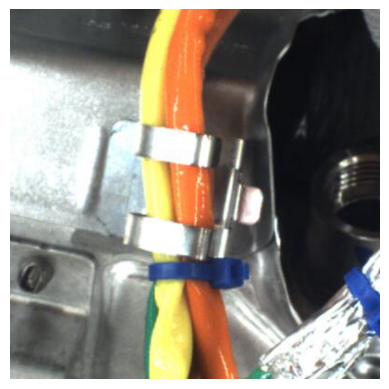

In [20]:
folder_path = '/home/jgayraud/Documents/MIC3/BE/engine_wiring/test/blue_hoop'
target_size = (400, 400)  
images, filenames = load_images_from_folder(folder_path, target_size)

images = normalize(images)

plotimage(images,3)